# Correr experimentos
En este archivo está el código para correr los experimentos y escribir los resultados en archivos CSV.
> Los archivos se guardan en la carpeta _resultados_.

In [1]:
import math, subprocess
import pandas as pd
import numpy as np
import random, math
import os
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt

eps = 10e-15
alpha = 10e7
experimentos = []

## Métodos de Eliminación Gausseana
- eliminacion_gausseana_SP
- eliminacion_gausseana_CP
- eliminacion_gausseana_TR_SinPre
- eliminacion_gausseana_TR_Pre

In [2]:
# Lectura de Matriz
def leer_matriz(path_instancia):
    A = np.loadtxt(path_instancia)
    return A

In [3]:
def agregar_experimentos(dataframe):
    counter = 0
    while counter < len(dataframe):
        fila = dataframe.iloc[counter]
        experimentos.append([fila["dataset"], fila["archivo-A"], fila["archivo-b"], fila["n"]])
        counter = counter + 1

In [4]:
def agregar_experimentos_A(dataframe):
    counter = 0
    while counter < len(dataframe):
        fila = dataframe.iloc[counter]
        experimentos_A.append([fila["dataset"], fila["archivo"], fila["n"]])
        counter = counter + 1

In [5]:
def agregar_experimentos_b(dataframe):
    counter = 0
    while counter < len(dataframe):
        fila = dataframe.iloc[counter]
        experimentos_b.append([fila["dataset"], fila["archivo"], fila["n"]])
        counter = counter + 1

## Algoritmos

### Eliminación Gausseana sin Pivot

In [6]:
# Eliminación Gausseana sin Pivoteo
def eliminacion_gausseana_SP(A, b):
  try:
    start_time = time.time()
    post_triangulacion = triangular_matriz_SP(A, b)

    A_trig = post_triangulacion[0]
    b_trig = post_triangulacion[1]

    bw_S = backward_substitution(A_trig, b_trig)

    return [bw_S, (time.time() - start_time)]
  except Exception as e:
    print(e)

In [7]:
def triangular_matriz_SP(A, b): 
  n = len(A)
  try:
    for i in range(0, n-1):
      for j in range(i+1, n):
        m_ji = A[j][i] / A[i][i]
        for k in range(i, n):
          A[j][k] = A[j][k] - (m_ji*A[i][k])
        b[j] = b[j] - b[i]*m_ji
    return[A, b]
  except: 
    raise Exception("No se pudo triangular porque se requiere un pivot o hubo un error durante la ejecución del algoritmo.")

In [8]:
# PREGUNTAR QUE SE HACE SI A[I][I] ES 0 LUEGO DE LA TRIANGULACIÓN - EXCEPCIÓN
def backward_substitution(A, b):
  n = len(A)
  x = np.zeros(n)
  try:
    for i in range(n-1, -1, -1):
      b_i = b[i]
      sum = 0
      for j in range(i+1, n):
        sum = sum + A[i][j]*x[j]
      x_i = (b_i - sum) / A[i][i]
      x[i] = x_i
    return x
  except Exception as e: 
    raise Exception("No se pudo realizar el backward substitution porque hubo algún error durante la ejecución del algoritmo.")

### Eliminación Gausseana con Pivot

In [141]:
# Eliminación Gausseana sin Pivoteo
def eliminacion_gausseana_CP(A, b):
  try:
    start_time = time.time()
    post_triangulacion = triangular_matriz_CP(A, b)
    A_trig = post_triangulacion[0]
    b_trig = post_triangulacion[1]
    
    if(infinitas_soluciones(A_trig, b_trig)):
      print("Infinitas soluciones")
      return [b_trig, (time.time() - start_time)]

    if(sin_soluciones(A_trig, b_trig)):
      print("Sin soluciones")
      return [b_trig, (time.time() - start_time)]

    bw_S = backward_substitution(A_trig, b_trig)
    return [bw_S, (time.time() - start_time)]
    
  except Exception as e:
    print(e)

In [142]:
def triangular_matriz_CP(A, b): 
    n = len(A)

    for i in range(0, n-1):

        pivot = abs(A[i][i])
        l = i
        # Buscamos el nuevo pivot. El máximo valor en toda la columna.
        for j in range(i+1, n):
            abs_a = abs(A[j][i])
            if(abs_a > pivot):
                pivot = abs_a
                l = j

        if(l != i):
            # Permutamos la fila (i) con el (l)
            for k in range(i, n):
                # SWAP
                aux = A[l][k]
                A[l][k] = A[i][k]
                A[i][k] = aux

            # SWAP
            b_aux = b[i]
            b[i] = b[l]
            b[l] = b_aux
 
        if(A[i][i] != 0):
            # Permutado ya podemos continuar
            for j in range(i+1, n):
                # ALERTA
                alerta_div(A[i][i])
                if(A[j][i] != 0):
                    m_ji = A[j][i] / A[i][i]
                    for k in range(i, n):
                        # ALERTA
                        alerta_mult(A[i][k])
                        alerta_mult(m_ji)
                        A[j][k] = A[j][k] - (m_ji*A[i][k])
                    # ALERTA
                    alerta_mult(m_ji)
                    alerta_mult(b[i])
                    b[j] = b[j] - b[i]*m_ji
    return [A, b]

In [11]:
# PREGUNTAR QUE SE HACE SI A[I][I] ES 0 LUEGO DE LA TRIANGULACIÓN - EXCEPCIÓN
def backward_substitution_CP(A, b):
  n = len(A)
  x = np.zeros(n)
  try:
    for i in range(n-1, -1, -1):
      b_i = b[i]
      sum = 0
      for j in range(i+1, n):
        # ALERTA
        alerta_mult(x[j])
        alerta_mult(A[i][j])
        
        sum = sum + A[i][j]*x[j]

      # ALERTA
      alerta_div(A[i][i])
      x_i = (b_i - sum) / A[i][i]

      x[i] = x_i
    return x
  except Exception as e: 
    raise Exception("No se pudo realizar el backward substitution porque hubo algún error durante la ejecución del algoritmo.")

In [12]:
def infinitas_soluciones(A, b):
  alguna_zero = False
  for i in range(0, len(A)):
    todos_zeros = True
    for j in range(0, len(A)):
      if(A[i][j] != 0):
        todos_zeros = False
    if(todos_zeros):
      if(b[i] == 0):
        alguna_zero = True

  return alguna_zero

In [13]:
def sin_soluciones(A, b):
  alguna_zero = False
  for i in range(0, len(A)):
    todos_zeros = True
    for j in range(0, len(A)):
      if(A[i][j] != 0):
        todos_zeros = False
    if(todos_zeros):
      if(b[i] != 0):
        alguna_zero = True

  return alguna_zero

In [14]:
# Metodo que define el valor absoluto
def abs(k):
  if k < 0:
    return (-1)*k
  return k

In [15]:
def alerta_div(k):
  if(-eps < k < eps):
    print("Este error puede afectar al resultado por uso de un número muy chico")

def alerta_mult(k):
  if(k > alpha or k < -alpha):
    print("Este error puede afectar al resultado por uso de un número muy grande")

### Eliminación Gausseana para una Tridiagonal sin Precomputo

In [16]:
# Eliminación Gausseana sin Pivoteo
def eliminacion_gausseana_TR_SinPre(a, b, c, d):
  # a[0] = 0
  # c[n-1] = 0
  try:
    start_time = time.time()
    triag = triangular_matriz_TR_SinPre(a, b, c, d)
      
    res_bs = backward_substitution_TR_SinPre(triag[1],triag[2],triag[3])
    
    return [res_bs, (time.time() - start_time)]
  except Exception as e:
    print(e)

In [17]:
# CONSULTAR QUE PASA SI B[I] = 0
def triangular_matriz_TR_SinPre(a, b, c, d):
  n = len(b)
  try:
    for i in range(0, n-1):
      m_ji = a[i+1] / b[i]
      a[i+1] = 0
      b[i+1] = (b[i+1] - (c[i]*m_ji))
      d[i+1] = (d[i+1] - d[i]*m_ji)

    return [a,b,c,d]
  except Exception as e:
    print(e)

In [18]:
# PREGUNTAR QUE SE HACE SI A[I][I] ES 0 LUEGO DE LA TRIANGULACIÓN - EXCEPCIÓN
def backward_substitution_TR_SinPre(b, c, d):
  n = len(b)
  x = np.zeros(n, dtype='f')
  try:
    x[n-1] = d[n-1] / b[n-1]
    for i in range(n-2, -1, -1):
      x_i = (d[i] - c[i]*x[i+1]) / b[i]
      x[i] = x_i
    return x
    
  except Exception as e: 
    raise Exception("No se pudo realizar el backward substitution porque hubo algún error durante la ejecución del algoritmo.")

### Eliminación Gausseana para una Tridiagonal sin Precomputo

In [19]:
# Eliminación Gausseana sin Pivoteo
def eliminacion_gausseana_TR_Pre(a, b, c, d):
  # a[0] = 0
  # c[n-1] = 0
  n = len(a)
  x = np.zeros(n, dtype='f')
  
  try:
    start_time = time.time()
    for i in range(1, n):
      d[i] = (d[i] - d[i-1]*a[i])

    x[n-1] = d[n-1] / b[n-1]
    for i in range(n-2, -1, -1):
      x_i = (d[i] - c[i]*x[i+1]) / b[i]
      x[i] = x_i

    return [x, (time.time() - start_time)]
  except Exception as e:
    print(e)

In [20]:
def precomputo_abc(a, b, c):
  n = len(b)
  try:
    for i in range(0, n-1):
      m_ji = a[i+1] / b[i]
      a[i+1] = m_ji
      b[i+1] = (b[i+1] - (c[i]*m_ji))
      
    return a, b
  except Exception as e:
    print(e)

### Ejercicio 4a

Se leerán varias matrices y se las procederá a evaluar con los algoritmos:
- eliminacion_gausseana_CP
- eliminacion_gausseana_TR_SinPre

In [143]:
def construir_matriz_completa(a,b,c):
    n = len(b)
    A = np.zeros((n,n))
    for i in range(0, len(b)):
        A[i][i] = b[i]
        if i >= 1:
            A[i][i-1] = a[i]
        if i < len(b)-1:
            A[i][i+1] = c[i]
            
    return A

In [144]:
dfs={}
casos=["tr_edd", "tr_random", "tr_sdp"]
experimentos = []
metodos=["EG_PIVOT","EG_TRI"]
for caso in casos:
    dfs[caso]=pd.read_csv(F"instancias/{caso}/indice.csv")

for caso in casos:
    agregar_experimentos(dfs[caso])
    
if(not os.path.isdir("resultados")):
    os.mkdir("resultados")

In [145]:
# Experimentación con EG_Pivot y EG_Trig
columnas = ["dataset", "n", "metodo", "tiempo"];
filas = []
parametros = []
numero = 1
for experimento in experimentos:
    # Voy mostrando que experimento se esta ejecutando.
    clear_output(wait=True)
    display('Experimento: ' + str(numero) + "/" + str(len(experimentos)))
    numero += 1
    
    # Ejecutamos el experimento T veces y obtenemos la mediana.
    pathA = F"instancias/{experimento[0]}/{experimento[1]}"
    pathB = F"instancias/{experimento[0]}/{experimento[2]}"
    A = leer_matriz(pathA)
    b = leer_matriz(pathB)
    
    A_trig = A
    A_square = construir_matriz_completa(A[0], A[1], A[2])

    min_CP = 0.0
    min_SP = 0.0
    
    it = 0
    display('Inicio iteracion')
    EG_Pivot = eliminacion_gausseana_CP(A_square, b)
    min_CP = EG_Pivot[1]
    display('Pivot Done')
    
    EG_Trig = eliminacion_gausseana_TR_SinPre(A[0], A[1], A[2], b)
    min_SP = EG_Trig[1]
    display('Sin Pre Done')
    
    while(it < 100):
        EG_Pivot = eliminacion_gausseana_CP(A_square, b)
        EG_Trig = eliminacion_gausseana_TR_SinPre(A[0], A[1], A[2], b)
        
        if(EG_Pivot[1] < min_CP):
            min_CP = EG_Pivot[1]
            
        if(EG_Trig[1] < min_SP):
            min_SP = EG_Trig[1]
        it = it + 1
        display('Iteracion: ' + str(it))
        
    if(experimento[0] == "tr_edd"):
        filas.append(["EDD", len(b), "EG_Pivot", min_CP]);
        filas.append(["EDD", len(b), "EG_Tridg", min_SP]);
        
    if(experimento[0] == "tr_random"):
        filas.append(["RANDOM", len(b), "EG_Pivot", min_CP]);
        filas.append(["RANDOM", len(b), "EG_Tridg", min_SP]);
        
    if(experimento[0] == "tr_sdp"):
        filas.append(["SDP", len(b), "EG_Pivot", min_CP]);
        filas.append(["SDP", len(b), "EG_Tridg", min_SP]);     
        
df_resultado = pd.DataFrame(filas, columns=columnas);
df_resultado.to_csv("resultados/resultado.csv", index=False, header=True);

'Experimento: 90/90'

'Inicio iteracion'

'Pivot Done'

'Sin Pre Done'

'Iteracion: 1'

'Iteracion: 2'

'Iteracion: 3'

'Iteracion: 4'

'Iteracion: 5'

'Iteracion: 6'

'Iteracion: 7'

'Iteracion: 8'

'Iteracion: 9'

'Iteracion: 10'

'Iteracion: 11'

'Iteracion: 12'

'Iteracion: 13'

'Iteracion: 14'

'Iteracion: 15'

'Iteracion: 16'

'Iteracion: 17'

'Iteracion: 18'

'Iteracion: 19'

'Iteracion: 20'

'Iteracion: 21'

'Iteracion: 22'

'Iteracion: 23'

'Iteracion: 24'

'Iteracion: 25'

'Iteracion: 26'

'Iteracion: 27'

'Iteracion: 28'

'Iteracion: 29'

'Iteracion: 30'

'Iteracion: 31'

'Iteracion: 32'

'Iteracion: 33'

'Iteracion: 34'

'Iteracion: 35'

'Iteracion: 36'

'Iteracion: 37'

'Iteracion: 38'

'Iteracion: 39'

'Iteracion: 40'

'Iteracion: 41'

'Iteracion: 42'

'Iteracion: 43'

'Iteracion: 44'

'Iteracion: 45'

'Iteracion: 46'

'Iteracion: 47'

'Iteracion: 48'

'Iteracion: 49'

'Iteracion: 50'

'Iteracion: 51'

'Iteracion: 52'

'Iteracion: 53'

'Iteracion: 54'

'Iteracion: 55'

'Iteracion: 56'

'Iteracion: 57'

'Iteracion: 58'

'Iteracion: 59'

'Iteracion: 60'

'Iteracion: 61'

'Iteracion: 62'

'Iteracion: 63'

'Iteracion: 64'

'Iteracion: 65'

'Iteracion: 66'

'Iteracion: 67'

'Iteracion: 68'

'Iteracion: 69'

'Iteracion: 70'

'Iteracion: 71'

'Iteracion: 72'

'Iteracion: 73'

'Iteracion: 74'

'Iteracion: 75'

'Iteracion: 76'

'Iteracion: 77'

'Iteracion: 78'

'Iteracion: 79'

'Iteracion: 80'

'Iteracion: 81'

'Iteracion: 82'

'Iteracion: 83'

'Iteracion: 84'

'Iteracion: 85'

'Iteracion: 86'

'Iteracion: 87'

'Iteracion: 88'

'Iteracion: 89'

'Iteracion: 90'

'Iteracion: 91'

'Iteracion: 92'

'Iteracion: 93'

'Iteracion: 94'

'Iteracion: 95'

'Iteracion: 96'

'Iteracion: 97'

'Iteracion: 98'

'Iteracion: 99'

'Iteracion: 100'

### Ejercicio 4b

Se leerán varias matrices tridiagonales. Se las evaluará con el algoritmo

In [87]:
dfs_A={}
dfs_b={}
casos=["tr_random_l", "tr_sdp_l", "tr_edd_l"]

experimentos_A = []
experimentos_b = []
metodos=["EG_TRI", "EG_TRI_PRE"]

for caso in casos:
    csv_data = pd.read_csv(F"instancias/{caso}/indice.csv")
    dfs_A[caso]=csv_data[csv_data["type"] == "A"].copy()
    dfs_b[caso]=csv_data[csv_data["type"] == "b"].copy()

for caso in casos:
    agregar_experimentos_A(dfs_A[caso])
    agregar_experimentos_b(dfs_b[caso])
    
if(not os.path.isdir("resultados")):
    os.mkdir("resultados")

In [137]:
columnas = ["dataset", "n", "metodo", "tiempo", "d"];
filas = []
parametros = []
numero = 1
position = 0

for i in range(0, len(experimentos_A)):
    experimento_a = experimentos_A[i]
    
    # Ejecutamos el experimento T veces y obtenemos la mediana.
    pathA = F"instancias/{experimento_a[0]}/{experimento_a[1]}"
    A = leer_matriz(pathA)
    a_CPre = A[0].copy()
    a_SPre = A[0].copy()
    a_CPre, b_CPre = precomputo_abc(a_CPre, A[1], A[2])
    
    tiempo_con = 0.0
    tiempo_sin = 0.0

    for j in range(0, 1001):
        experimento_b = experimentos_b[position]
        pathB = F"instancias/{experimento_b[0]}/{experimento_b[1]}"
        d = leer_matriz(pathB)
        
        EG_CPre = eliminacion_gausseana_TR_Pre(a_CPre, b_CPre, A[2], d)
        EG_SPre = eliminacion_gausseana_TR_SinPre(a_SPre, A[1], A[2], d)

        tiempo_con = tiempo_con + EG_CPre[1]
        tiempo_sin = tiempo_sin + EG_SPre[1]
        
        if(experimento_a[0] == "tr_edd_l"):
            filas.append(["EDD", len(d), "EG_PreC", tiempo_con, j]);
            filas.append(["EDD", len(d), "EG_SinC", tiempo_sin, j]);
        if(experimento_a[0] == "tr_sdp_l"): 
            filas.append(["SDP", len(d), "EG_PreC", tiempo_con, j]);
            filas.append(["SDP", len(d), "EG_SinC", tiempo_sin, j]);
        if(experimento_a[0] == "tr_random_l"): 
            filas.append(["RANDOM", len(d), "EG_PreC", tiempo_con, j]);
            filas.append(["RANDOM", len(d), "EG_SinC", tiempo_sin, j]);

        clear_output(wait=True)
        display('Experimento: ' + str(numero) + "/" + str(len(experimentos_A)))
        display('d_valor: ' + str(j) +  "/" + str(1001))
        
        position = position + 1
    numero += 1

df_resultado = pd.DataFrame(filas, columns=columnas);
df_resultado.to_csv("resultados/resultado-PSComputo.csv", index=False, header=True);

'Experimento: 3/3'

'd_valor: 3002/1001'

### Ejercicio 5 - Derivada Segunda

In [21]:
def ejercicio_5(n):
  d1 = np.zeros(n, dtype="d")
  d2 = np.zeros(n, dtype="d")
  d3 = np.zeros(n, dtype="d")
  a = np.zeros(n, dtype="d")
  b = np.zeros(n, dtype="d")
  c = np.zeros(n, dtype="d")

  try:
    index = int(n/2) + 1
    d1[index] = 4/n
      
    for i in range (0,n):
      d2[i] = (4 / (n**2))
      d3[i] = (-1 + (2*i / (n-1)))*(12 / n**2)

      a[i] = 1
      c[i] = 1
      b[i] = -2

    a[0] = 0
    c[n-1] = 0

    a, b = precomputo_abc(a, b, c)

    u1 = eliminacion_gausseana_TR_Pre(a, b, c, d1)
    u2 = eliminacion_gausseana_TR_Pre(a, b, c, d2)
    u3 = eliminacion_gausseana_TR_Pre(a, b, c, d3)

    return [u1[0],u2[0],u3[0]]
  except Exception as e:
    print(e)

In [22]:
derivadas = ejercicio_5(101)

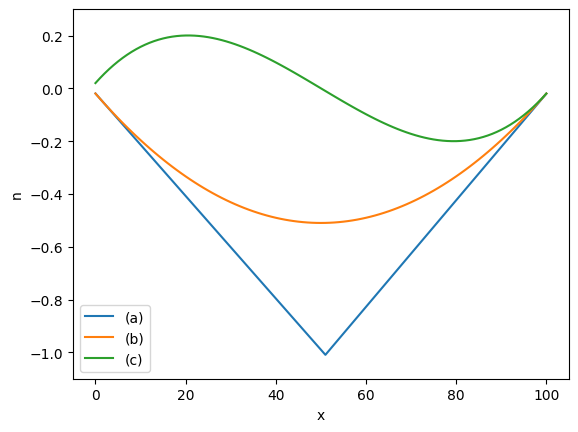

In [23]:
plt.plot(derivadas[0], label="(a)")
plt.plot(derivadas[1], label="(b)")
plt.plot(derivadas[2], label="(c)")
plt.legend(loc='lower left')
plt.ylim([-1.1, 0.30])
plt.xlabel('x')
plt.ylabel('n')
plt.savefig("graficos/difusion-5.svg");
plt.show()

### Ejercicio 6 - Difusión

In [24]:
def ejercicio6(n, r, it, alpha):
  try:
    a = np.zeros(n, dtype="d")
    b = np.zeros(n, dtype="d")
    c = np.zeros(n, dtype="d")
    d = np.zeros(n, dtype="d")

    for i in range (0, n):
      if((int(n/2) - r) < i < (int(n/2) + r)):
        d[i] = 1

      a[i] = -1*alpha
      c[i] = -1*alpha
      b[i] = (2*alpha + 1)
    a[0] = 0
    c[-1] = 0

    d_0 = d.copy()
    conjunto = [d_0]
    a, b = precomputo_abc(a, b, c)

    i = 0
    while(i < it):
      uk = eliminacion_gausseana_TR_Pre(a,b,c,d)
      d_cte = uk[0].copy()
      conjunto.append(d_cte)
      d = uk[0]
      i = i + 1
    
    return conjunto
  except Exception as e:
    print(e)

In [25]:
n = 101
r = 10
it = 1001
ej_alpha = 1

In [26]:
datos = ejercicio6(n, r, it, ej_alpha)

In [27]:
datos_transpose = np.transpose(datos)

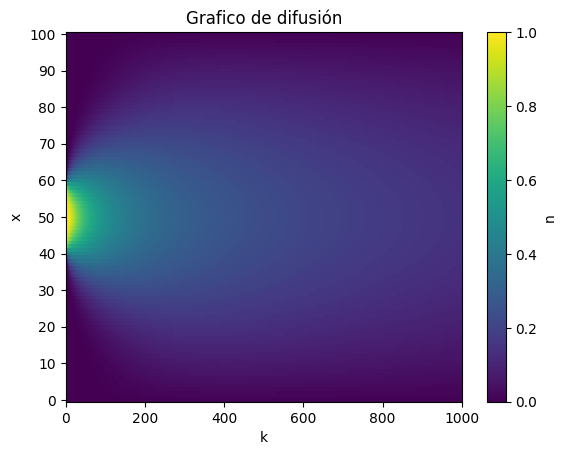

In [28]:
ax = plt.subplot()
im = ax.imshow(datos_transpose, interpolation='nearest', aspect='auto')
ax.set_title('Grafico de difusión')
plt.colorbar(im, ax=ax, label="n")
plt.yticks(np.arange(0, 101, 10))
plt.xlabel("k")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.savefig("graficos/heatmap-difusion-alpha1.svg");
plt.show()

In [29]:
ej_alpha = 0.1
datos = ejercicio6(n, r, it, ej_alpha)
datos_transpose = np.transpose(datos)

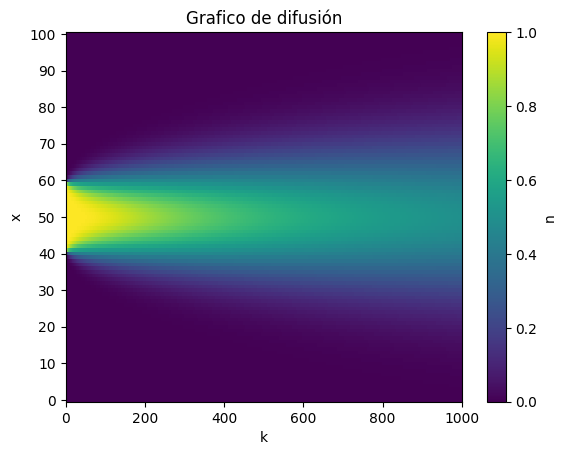

In [30]:
ax = plt.subplot()
im = ax.imshow(datos_transpose, interpolation='nearest', aspect='auto')
ax.set_title('Grafico de difusión')
plt.colorbar(im, ax=ax, label="n")
plt.yticks(np.arange(0, 101, 10))
plt.xlabel("k")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.savefig("graficos/heatmap-difusion-alpha01.svg");
plt.show()

In [31]:
ej_alpha = 10
datos = ejercicio6(n, r, it, ej_alpha)
datos_transpose = np.transpose(datos)

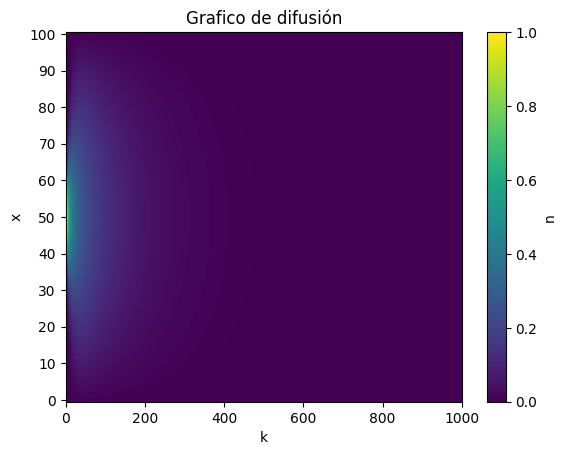

In [32]:
ax = plt.subplot()
im = ax.imshow(datos_transpose, interpolation='nearest', aspect='auto')
ax.set_title('Grafico de difusión')
plt.colorbar(im, ax=ax, label="n")
plt.yticks(np.arange(0, 101, 10))
plt.xlabel("k")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.savefig("graficos/heatmap-difusion-alpha10.svg");
plt.show()

### Algunos casos de prueba usados durante la construicción de los algoritmos

In [33]:
# Sin triangular
A = np.array([[1,2,3,4], [1,4,9,16], [1,8,27,64], [1, 16, 81, 256]])
b = np.array([2,10,44,190])
EG = eliminacion_gausseana_SP(A, b)
print(EG)

[array([-1.,  1., -1.,  1.]), 0.0]


In [34]:
# Sin triangular
A = np.array([[2,1,-1,3], [-2,0,0,0], [4,1,-2,4], [-6,-1,2,-3]])
b = np.array([13,-2,24,-10])
EG = eliminacion_gausseana_SP(A, b)
print(EG)

[array([  1., -30.,   7.,  16.]), 0.0010020732879638672]


In [35]:
# Triangulado
A = np.array([[2,1,-1,3], [0,1,-1,3], [0,0,-1,1], [0,0,0,1]])
b = np.array([13,11,9,16])
EG = eliminacion_gausseana_SP(A, b)
print(EG)

[array([  1., -30.,   7.,  16.]), 0.00110626220703125]


In [36]:
# Sin triangular - Decimales chicos
A = np.array([[0.0000002,1,-1,3], [-0.0000002,0,0,0], [0.0000004,1,-2,4], [-0.0000006,-1,2,-3]])
b = np.array([13,-2,24,-10])
EG = eliminacion_gausseana_SP(A, b)
print(EG)

[array([ 1.0e+07, -3.0e+01,  7.0e+00,  1.6e+01]), 0.0]


In [37]:
# Matriz con decimales no tan bajos
A = np.array([[0.003, 0.217], [0.277, 0.138]])
b = np.array([0.437,0.553])
EG = eliminacion_gausseana_SP(A, b)
print(EG)

[array([1., 2.]), 0.0]


In [38]:
# Falla al intentar triangular porque no hay pivot
A = np.array([[0, 0, 0, 0, 0, 0], [0, -1, 0, 0, 0, -0.08], [0, 1, -1, 0, 1, 0], [0, 0, 1, -1, 0, 0.02], [1, 0, 0, 1, 0, 0.05], [0, 0, 0, 0, 0, 0.05]])
b = np.array([0,0,0,0,0,0])
EG = eliminacion_gausseana_SP(A, b)
print(EG)

No se pudo triangular porque se requiere un pivot o hubo un error durante la ejecución del algoritmo.
None


C:\Proyectos\metodos-tp1-1c2023\entorno\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [62]:
# Canónico
A = np.array([[0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
b = np.array([0,0,0,0,0,0])
EG = eliminacion_gausseana_CP(A, b)
print(EG)

[array([0., 0., 0., 0., 0., 0.]), 0.0010118484497070312]


In [63]:
# Canónico
A = np.array([[0, 1, 0, 0, 0, 0],[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0],[0, 0, 0, 0, 0, 1],[0, 0, 0, 1, 0, 0],[0, 0, 0, 0, 1, 0]])
b = np.array([1,2,3,4,5,6])
EG = eliminacion_gausseana_CP(A, b)
print(EG)

[array([2., 1., 3., 5., 6., 4.]), 0.0]


In [69]:
# Canónico - Sin Solucion
A = np.array([[1, 1],[2, 2]], dtype="f")
b = np.array([2,5], dtype="f")
EG = eliminacion_gausseana_CP(A, b)
print(EG)

Sin soluciones
[array([ 5. , -0.5], dtype=float32), 0.0]


In [70]:
# Canónico - Solucion infinita
A = np.array([[1, 1],[2, 2]])
b = np.array([2,4])
EG = eliminacion_gausseana_CP(A, b)
print(EG)

Infinitas soluciones
[array([4, 0]), 0.0]


In [74]:
# Sin triangular - Decimales chicos
A = np.array([[0.0000000000000002,1,-1,3], [2,0.0000000000000002,0,0], [4,1,-2,4], [-6,-1,2,-3]])
b = np.array([13,-2,24,-10])
EG = eliminacion_gausseana_CP(A, b)
print(EG)
# Es Singular
# X = np.linalg.solve(A, b)

[array([-5.00000000e-01, -2.30000000e+01,  2.39808173e-14,  1.20000000e+01]), 0.0]


In [75]:
# Sin triangular
A = np.array([[2,1,-1,3], [-2,0,0,0], [4,1,-2,4], [-6,-1,2,-3]], dtype="f")
b = np.array([13,-2,24,-10], dtype="f")
EG = eliminacion_gausseana_CP(A, b)
print(EG)

[array([  0.99999954, -29.99999627,   6.99999619,  15.99999714]), 0.0009980201721191406]


In [57]:
# Elementos con decimales
A = np.array([[1,eps,-1,3], [-2,eps,0,0], [4,1,eps,4], [-6,-1,2,eps]])
b = np.array([13,-2,24,-10])
EG = eliminacion_gausseana_CP(A, b)
print(EG)

[array([1.16666667, 4.6       , 0.8       , 3.6       ]), 0.0010051727294921875]


In [135]:
# Elementos con decimales
A = np.array([[0,2,6,4], [4,6,1,5], [2,3,6,4], [6,8,-7,2]])
b = np.array([1,1,1,1])
EG = eliminacion_gausseana_CP(A, b)
print(EG)

[[ 6  8 -7  2]
 [ 0  0  5  3]
 [ 0  0  8  3]
 [ 0  2  6  4]]
[[ 6  8 -7  2]
 [ 0  2  6  4]
 [ 0  0  8  3]
 [ 0  0  5  3]]
[[ 6  8 -7  2]
 [ 0  2  6  4]
 [ 0  0  8  3]
 [ 0  0  0  1]]
[[ 6  8 -7  2]
 [ 0  2  6  4]
 [ 0  0  8  3]
 [ 0  0  0  1]]
[1 1 0 0]
[array([-0.5,  0.5,  0. ,  0. ]), 0.002021312713623047]


In [58]:
# Error obtenido
4.02640884 - 4.03889885

-0.012490009999999607

In [426]:
# Elementos con decimales
a = np.array([0,1,2,3,4], dtype='d')
b = np.array([1,1,1,1,1], dtype='d')
c = np.array([5,9,12,5,0], dtype='d')
d = np.array([1,2,3,4,5], dtype='d')

EG = eliminacion_gausseana_TR_SinPre(a, b, c, d)
print(EG)

[array([17.103203 , -3.2206407, -1.3202847,  0.8967972,  1.4128114],
      dtype=float32), 0.0]


In [427]:
# Elementos con decimales
a = np.array([0,1,2,3,4], dtype='d')
b = np.array([1,1,1,1,1], dtype='d')
c = np.array([5,9,12,5,0], dtype='d')
d = np.array([1,2,3,4,5], dtype='d')

# Podemos preguntar sobre errores de precisión
a, b = precomputo_abc(a, b, c)

# Para todos los d distintos
eg_triag_precomputado = eliminacion_gausseana_TR_Pre(a, b, c, d)

print(eg_triag_precomputado[0])
#a = np.array([0,1,2,3,4], dtype='d')
#b = np.array([1,1,1,1,1], dtype='d')
#c = np.array([5,9,12,5,0], dtype='d')
#d = np.array([1,2,3,4,5], dtype='d')
#
#eg_triag_sinprecomputado = eliminacion_gausseana_TR_SinPre(a, b, c, d)

[17.103203  -3.2206407 -1.3202847  0.8967972  1.4128114]


In [428]:
A_tridiagonal_np = np.array([
    [1.0 ,5.0 ,0.0 ,0.0  ,0.0 ],
    [1.0 ,1.0 ,9.0 ,0.0  ,0.0 ],
    [0.0 ,2.0 ,1.0 ,12.0 ,0.0 ],
    [0.0 ,0.0 ,3.0 ,1.0  ,5.0 ],
    [0.0 ,0.0 ,0.0 ,4.0  ,1.0 ]
])
d_tridiagonal_np = np.array([1,2,3,4,5], dtype='d')
res = np.linalg.solve(A_tridiagonal_np, d_tridiagonal_np)
print(res)

[17.10320285 -3.22064057 -1.3202847   0.89679715  1.41281139]


In [429]:
A_tridiagonal_CP = np.array([
    [1.0,5.0,0.0,0.0,0.0],
    [1.0,1.0,9.0,0.0,0.0],
    [0.0,2.0,1.0,12.0,0.0],
    [0.0,0.0,3.0,1.0,5.0],
    [0.0,0.0,0.0,4.0,1.0]
])
d_tridiagonal_CP = np.array([1,2,3,4,5], dtype='d')
trigiagonal_CP = eliminacion_gausseana_CP(A_tridiagonal_CP, d_tridiagonal_CP)